In [198]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import datetime
import pandas_datareader as data
import math

In [199]:
SPY_Firms = pd.read_csv('Firm_SPY500.csv', index_col = 'Symbol')

In [200]:
#discuss length being 505 see wiki

In [202]:
#create list of all Firm Symbol(Tickers) for looping purposes
Symbols = []
for symbol in SPY_Firms.index:
    Symbols.append(symbol)
Symbols.sort()

In [4]:
#Import Data on each stock for last 30 days as dictionary
start = datetime.datetime(2021,10,11)
end = datetime.datetime(2021,11,22)
d = {}
for symbol in Symbols:
        try:
            d[symbol] = data.DataReader(symbol, 
                       start=start, 
                       end=end, 
                       data_source='yahoo')
        except KeyError:
            print('uh oh')

In [5]:
#Convert dictionary to DataFrame through concatination of dictionary values
Firms_SPY500_30 = pd.concat(d.values(),axis = 1, keys = Symbols)
Firms_SPY500_30.columns.names = ['Symbol', 'Info']
Firms_SPY500_30.to_pickle('Firms_SPY500_30.pkl')

In [6]:
#Show how no missing Data, speak a little about bias.

In [7]:
#DataFrame of solely the adjusted returns, talk about why adj vs close
Firms_SPY500_30_Adj = Firms_SPY500_30.xs(key = 'Adj Close', axis = 1, level='Info')

In [8]:
#Create DataFrame of Daily Returns for each stock
Firms_Daily_Return_30 = pd.DataFrame()
for symbol in Symbols:
    Firms_Daily_Return_30[symbol] = Firms_SPY500_30_Adj[symbol].pct_change()

In [9]:
#Create DataFrame for the cumulative returns of each stock
Firms_Daily_Return_30_Cum = (Firms_Daily_Return_30+1).cumprod() - 1
Firms_Daily_Return_30_Cum.tail(1)

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-22,0.085055,-0.024839,0.092919,0.129158,0.060831,-0.006823,0.009544,0.075835,0.116014,0.175371,...,0.061979,0.420941,0.012616,-0.084135,0.076584,0.036639,-0.094374,0.22274,0.061019,0.136392


In [103]:
#Verify Using Numpy
#(df_adj['AAPL'].loc[end] - df_adj['AAPL'].loc[start])/(df_adj['AAPL'].loc[start])
a = pd.DataFrame(((Firms_SPY500_30_Adj.loc[end] - Firms_SPY500_30_Adj.loc[start])/Firms_SPY500_30_Adj.loc[start]))
b = Firms_Daily_Return_30_Cum.tail(1).transpose()
b.index.names = ['Symbol']
c = a.merge(b, on = 'Symbol')
c.columns = ['a', 'b']
c['Difference'] = (c['a'] - c['b']).abs()
len(c[c['Difference'] > (1*(10**-14))])

0

In [104]:
#Create DataFrame of 30 day cumulative Return with firm info
Firms_Daily_Return_30_Cum_Total = pd.DataFrame(Firms_Daily_Return_30_Cum.iloc[-1])
Firms_Daily_Return_30_Cum_Total.columns = ['30d Return']
Firms_Daily_Return_30_Cum_Total.index.name = ('Symbol')
SPY_Firms_30d_Returns = pd.DataFrame(SPY_Firms.merge(Firms_Daily_Return_30_Cum_Total, on= 'Symbol'))
SPY_Firms_30d_Returns.drop(columns = ['Unnamed: 0', 'Headquarters Location'], inplace = True)
SPY_Firms_30d_Returns.set_index('Symbol').sort_values('Symbol')

,Security,GICS Sector,30d Return
Symbol,,,
A,Agilent Technologies,Health Care,0.085055
AAL,American Airlines Group,Industrials,-0.024839
AAP,Advance Auto Parts,Consumer Discretionary,0.092919
AAPL,Apple,Information Technology,0.129158
ABBV,AbbVie,Health Care,0.060831
...,...,...,...
YUM,Yum! Brands,Consumer Discretionary,0.036639
ZBH,Zimmer Biomet,Health Care,-0.094374
ZBRA,Zebra Technologies,Information Technology,0.222740


<AxesSubplot:>

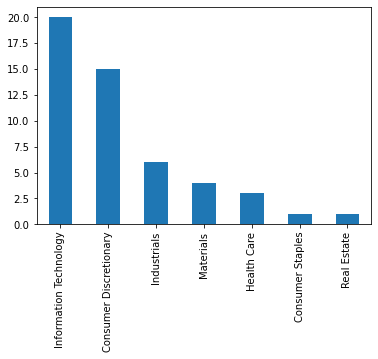

In [113]:
#What sector do the top perfomring stock belong to 
###Insight 1, part 1. Note 2 sectors dominates
Top_Ten_Firms = SPY_Firms_30d_Returns.sort_values('30d Return', ascending = False).head(50)
Top_Ten_Firms['GICS Sector'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

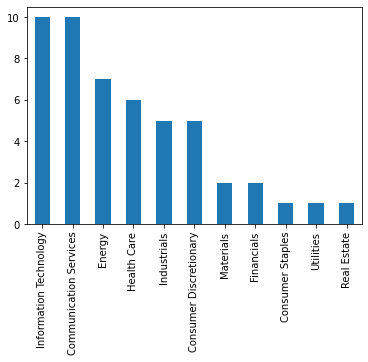

In [114]:
#Bottom 10 Performing Stocks
###Insight 1, part 2.Indeed presence of IT again says something which should prompt overall analysis of sectorsBo
Bottom_Ten_Firms = SPY_Firms_30d_Returns.sort_values('30d Return', ascending = True).head(50)
Bottom_Ten_Firms['GICS Sector'].value_counts().plot(kind = 'bar')

<AxesSubplot:ylabel='GICS Sector'>

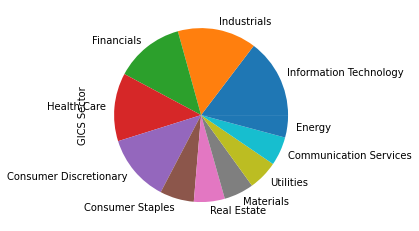

In [116]:
#Check for over  representation
SPY_Firms_30d_Returns['GICS Sector'].value_counts().plot(kind = 'pie')

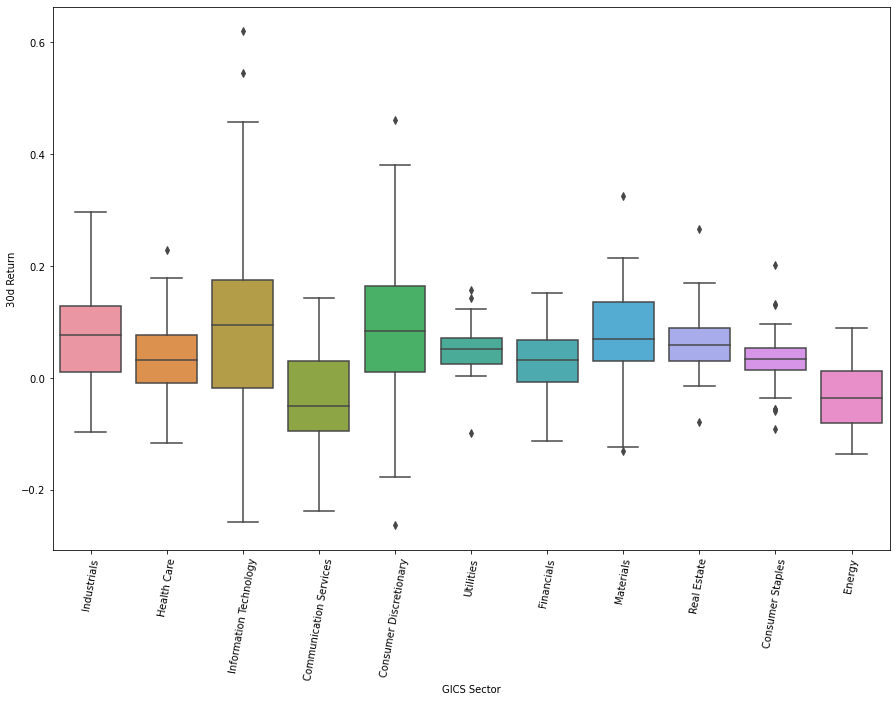

In [117]:
#Insight 2. Measure of skewness and distribution, we can see IT is very spread out vs utilites compact.
fig = plt.figure(figsize = (15,10))
a = sns.boxplot(x = SPY_Firms_30d_Returns['GICS Sector'], y = SPY_Firms_30d_Returns['30d Return'],data = SPY_Firms_30d_Returns, showfliers = True)
a.set_xticklabels(a.get_xticklabels(),rotation=80)
plt.show(a)
#Include overall median performance line

In [118]:
#Repeat for standard Deviation. include top ten, bottom 10 and then boxplot
SPY_Firms_30d_STD = pd.DataFrame(Firms_SPY500_30_Adj.std())
SPY_Firms_30d_STD.columns = ['30d Standard Deviation']
SPY_Firms_30d_STD = SPY_Firms.merge(SPY_Firms_30d_STD, on = 'Symbol')
SPY_Firms_30d_STD.drop(columns = ['Unnamed: 0', 'Headquarters Location'], inplace = True)
SPY_Firms_30d_STD = SPY_Firms_30d_STD.set_index('Symbol').sort_values('Symbol')

<AxesSubplot:>

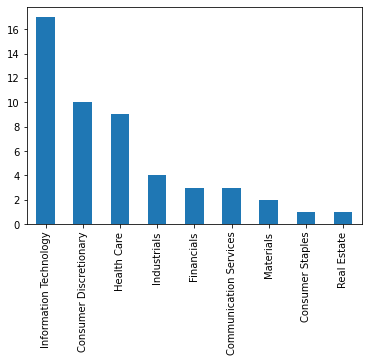

In [126]:
#Top 10 volatile stock
Most_vol = (SPY_Firms_30d_STD.sort_values('30d Standard Deviation', ascending = False)).head(50)
Most_vol['GICS Sector'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

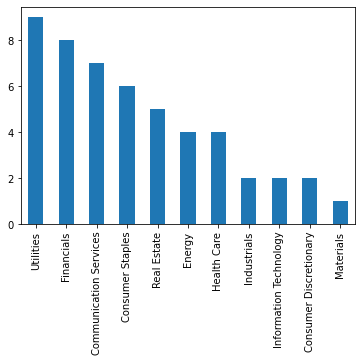

In [127]:
Least_Vol = (SPY_Firms_30d_STD.sort_values('30d Standard Deviation', ascending = True)).head(50)
Least_Vol['GICS Sector'].value_counts().plot(kind = 'bar')

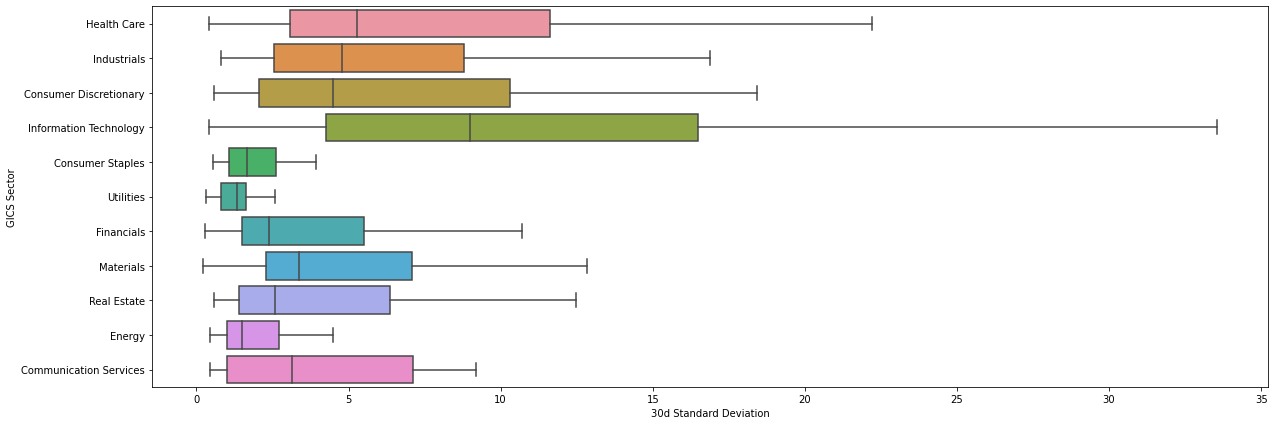

In [207]:
#std by sector, remember we're not looking for mean std of sector rather looking at how std's are spread out
#ignore outliers and hope for the best
fig = plt.figure(figsize = (20,7))
b = sns.boxplot(y = SPY_Firms_30d_STD['GICS Sector'], x = '30d Standard Deviation', data = SPY_Firms_30d_STD, showfliers = False)
b.set_yticklabels(b.get_yticklabels(),rotation=0)
plt.show(b)

In [208]:
Firm_corr_abs= pd.DataFrame(Firms_Daily_Return_30.corr().abs().unstack().sort_values(ascending = False)[505::2])
Firm_corr_abs.columns = ['Correlation Coefficient']
Firm_corr_abs.index.names = ['Symbol 1','Symbol 2']

In [320]:
Firm_corr = pd.DataFrame(Firms_Daily_Return_30.corr().unstack())
Firm_corr.columns = ['Correlation Coefficient']
Firm_corr.index.names = ['Symbol 1','Symbol 2']
m = pd.DataFrame(Firm_corr.merge(Firm_corr_abs, on = ['Symbol 1','Symbol 2'])['Correlation Coefficient_x'])
m.reset_index(inplace = True)
m = m

m.set_index('Symbol 1', inplace= True)
m['Symbol 1 Sector'] = 0
m['Symbol 2 Sector'] = 0
for each in m.index:
    m.loc[each, 'Symbol 2 Sector'] = SPY_Firms.loc[each]['GICS Sector']
    
m.reset_index(inplace = True)

m.set_index('Symbol 2', inplace= True)
for each in m.index:
    m.loc[each, 'Symbol 1 Sector'] = SPY_Firms.loc[each]['GICS Sector']
    
m.reset_index(inplace = True)
m.set_index('Symbol 1', inplace= True)
m.reset_index(inplace = True)

m.to_csv('Stock_Corr_wSec')

In [331]:
m = m.sort_values(by = 'Correlation Coefficient_x', ascending = True)
m['Sector Same'] = m['Symbol 1 Sector'] == m['Symbol 2 Sector']
m[m['Sector Same']]

,Symbol 1,Symbol 2,Correlation Coefficient_x,Symbol 1 Sector,Symbol 2 Sector,Sector Same
65049,JNPR,JKHY,-0.654836,Information Technology,Information Technology,True
69148,LEG,UAA,-0.641713,Consumer Discretionary,Consumer Discretionary,True
69147,LEG,UA,-0.637317,Consumer Discretionary,Consumer Discretionary,True
116611,UPS,LMT,-0.615564,Industrials,Industrials,True
47162,FISV,JNPR,-0.608203,Information Technology,Information Technology,True
...,...,...,...,...,...,...
48373,FOXA,FOX,0.983750,Communication Services,Communication Services,True
114692,UA,UAA,0.990303,Consumer Discretionary,Consumer Discretionary,True
81212,MTB,PBCT,0.991505,Financials,Financials,True
51666,GOOG,GOOGL,0.993857,Communication Services,Communication Services,True
